# Importando as bibliotecas

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

## Carregando os Dados

In [2]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

## Informações dos Dados


In [3]:
print('Tamanho dos dados:',df.shape)
print('Dados Duplicados:', df.duplicated().sum())

info_data = pd.DataFrame({
    'Unique':df.nunique(),
    'Null':df.isna().sum(),
    'NullPercent':round(df.isna().sum() / len(df)*100),
    'Type':df.dtypes.values
})
info_data

Tamanho dos dados: (5110, 12)
Dados Duplicados: 0


,Unique,Null,NullPercent,Type
id,5110,0,0.0,int64
gender,3,0,0.0,object
age,104,0,0.0,float64
hypertension,2,0,0.0,int64
heart_disease,2,0,0.0,int64
ever_married,2,0,0.0,object
work_type,5,0,0.0,object
Residence_type,2,0,0.0,object
avg_glucose_level,3979,0,0.0,float64
bmi,418,201,4.0,float64


- Observado a tabela, a coluna de BMI contém 201 dados faltantes. Quando chegar na parte de treinamento irei transformar está coluna utilizando o metódo de imputação. Mas no momento, estarei apenas visualizando os colunas graficamente.

In [4]:
df.drop('id', axis=1, inplace=True)
df = df[df['gender'] != 'Other']

## Gráficos

In [5]:
# identificando as colunas com valores únicos abaixo de 5, para usá-los no gráfico de pizza
for i in df.columns:
  if df[i].nunique() <=5:
    print(i)

gender
hypertension
heart_disease
ever_married
work_type
Residence_type
smoking_status
stroke


- Visualizando a porcentagem dos dados de cada coluna no conjunto de dados

In [6]:
fig = make_subplots(2,2,specs=[[{'type':'domain'},{'type':'domain'}],
                                [{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Gênero','Hypertension','Heart_Disease','Married'])

fig.add_trace(go.Pie(labels=df['gender'].value_counts().index, values=df['gender'].value_counts()),1,1)

fig.add_trace(go.Pie(labels=df['hypertension'].value_counts().index, values=df['hypertension'].value_counts()),1,2)

fig.add_trace(go.Pie(labels=df['heart_disease'].value_counts().index, values=df['heart_disease'].value_counts()),2,1)

fig.add_trace(go.Pie(labels=df['ever_married'].value_counts().index, values=df['ever_married'].value_counts()),2,2)

fig.update(layout_showlegend=False)
fig.show()

In [7]:
fig = make_subplots(2,2,specs=[[{'type':'domain'},{'type':'domain'}],
                                [{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Residence','Smoking','Stroke','Work Type'])

fig.add_trace(go.Pie(labels=df['Residence_type'].value_counts().index, values=df['Residence_type'].value_counts()),1,1)

fig.add_trace(go.Pie(labels=df['smoking_status'].value_counts().index, values=df['smoking_status'].value_counts()),1,2)

fig.add_trace(go.Pie(labels=df['stroke'].value_counts().index, values=df['stroke'].value_counts()),2,1)

fig.add_trace(go.Pie(labels=df['work_type'].value_counts().index, values=df['work_type'].value_counts()),2,2)

fig.update_traces(hole=.4)
fig.update(layout_showlegend=False)
fig.show()

- Podemos ver no gráfico que os dados estão desequilibrados, como a coluna 'Stroke', 'Hypertension', 'Heart Disease'.

- Agora vamos olhar mais de perto os valores únicos de cada coluna.

In [8]:
# selecionando os valores categóricos 
cat = df.select_dtypes(include='O')
for c in cat:
  print('-'*3,c,'-'*3)
  print(df[c].value_counts())
  print()

--- gender ---
Female    2994
Male      2115
Name: gender, dtype: int64

--- ever_married ---
Yes    3353
No     1756
Name: ever_married, dtype: int64

--- work_type ---
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

--- Residence_type ---
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

--- smoking_status ---
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64



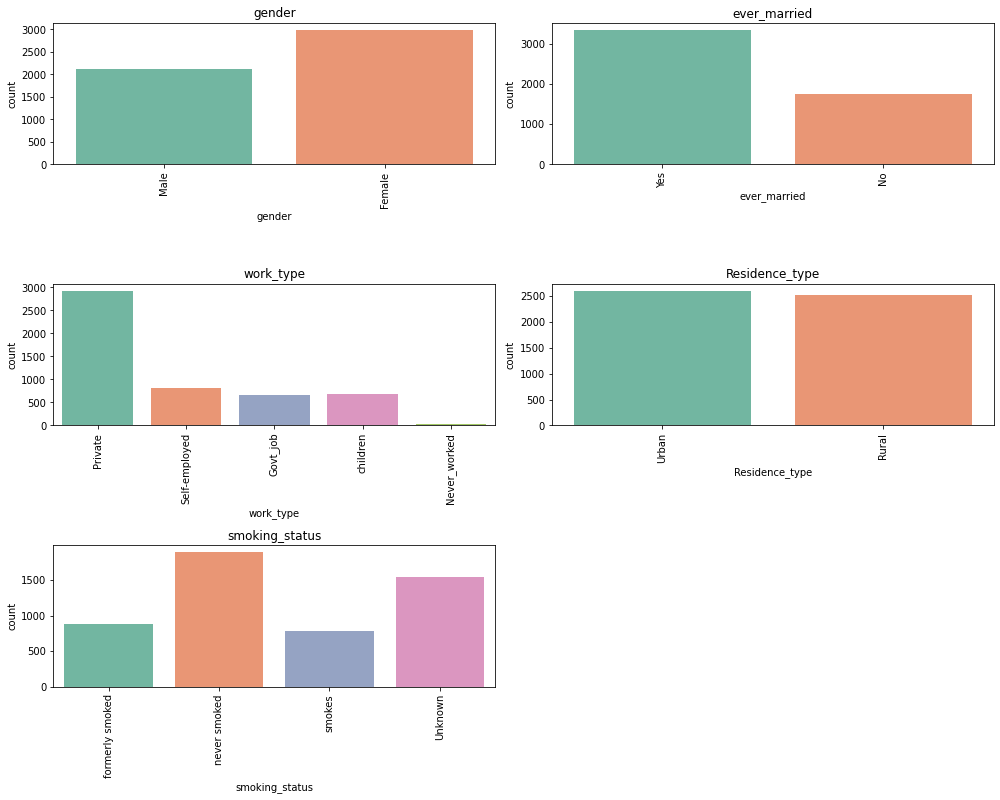

In [9]:
# visualizando a contagem de dados em colunas categóricas
plt.figure(figsize=(14,17))
for i, c in enumerate(cat):
  axes = plt.subplot(5,2, i + 1)
  sns.countplot(x=df[c], ax=axes, palette='Set2')
  plt.xticks(rotation=90);
  plt.title(c, fontsize=12)
plt.tight_layout()
plt.show()

- Vemos que o gênero feminino é maior que o público masculino, porém por ser em maior quantidade nos dados, elas são mais propensas a fumar do que os homens? Por serem em quantidade, as colunas seguintes tem uma forte relações com este gênero? 
- Nos status de Fumante pode-se observar que a maioria das pessoas não fumam, enquanto outros são desconhecido.

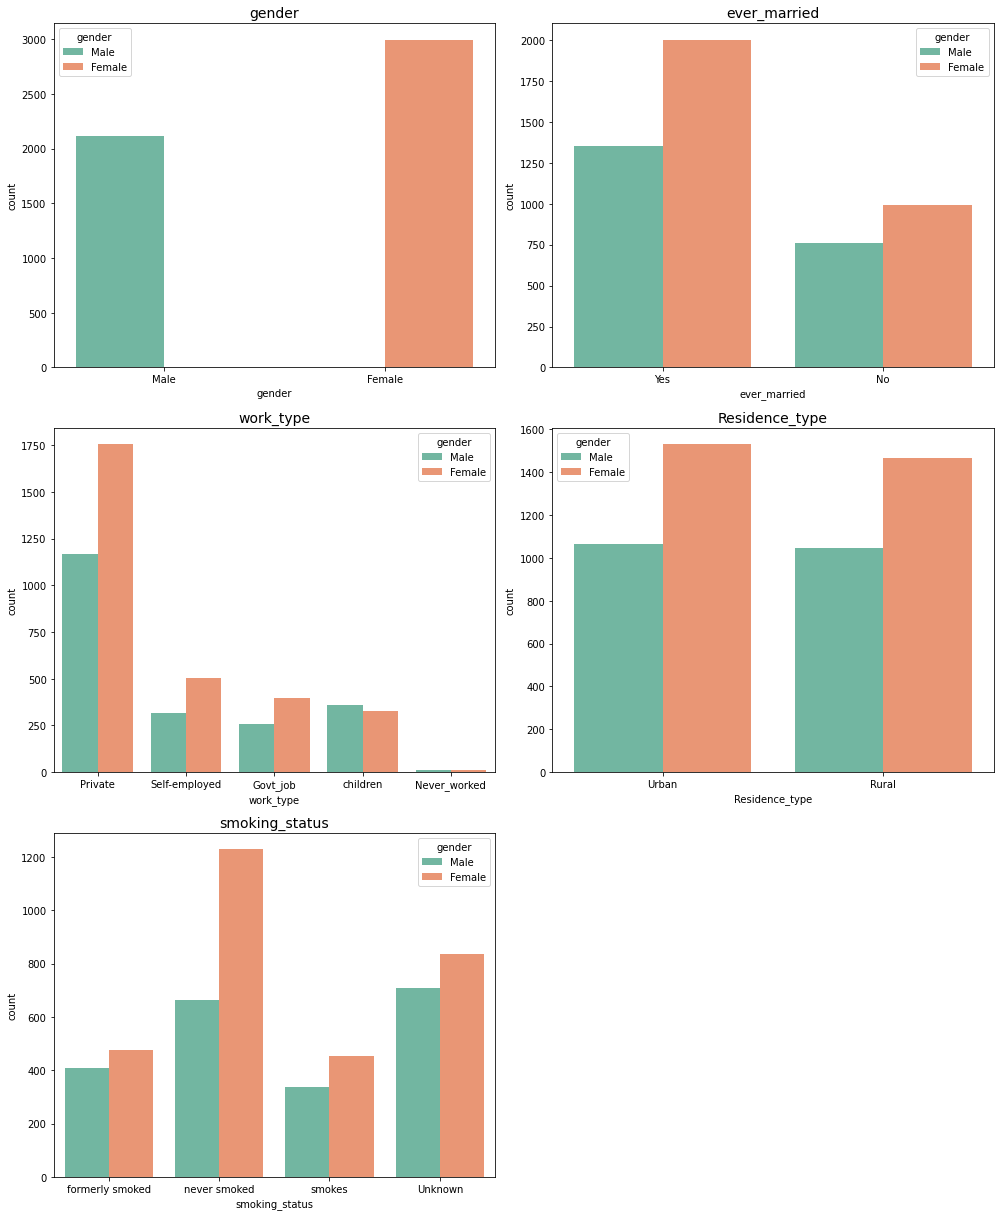

In [10]:
# Qual a relação dos gêneros com outras colunas?
plt.figure(figsize=(14,17))
for i, col in enumerate(cat):
  axes = plt.subplot(3,2, i + 1)
  sns.countplot(x=df[col], hue=df['gender'], ax=axes, palette='Set2')
  plt.title(col, fontsize=14)
plt.tight_layout()
plt.show()

- Respondendo a primeira pergunta, embora os dados apresentem uma quantidade pequena sobre fumantes, as mulheres são mais propensas a fumar e tem grande relação com as outras colunas

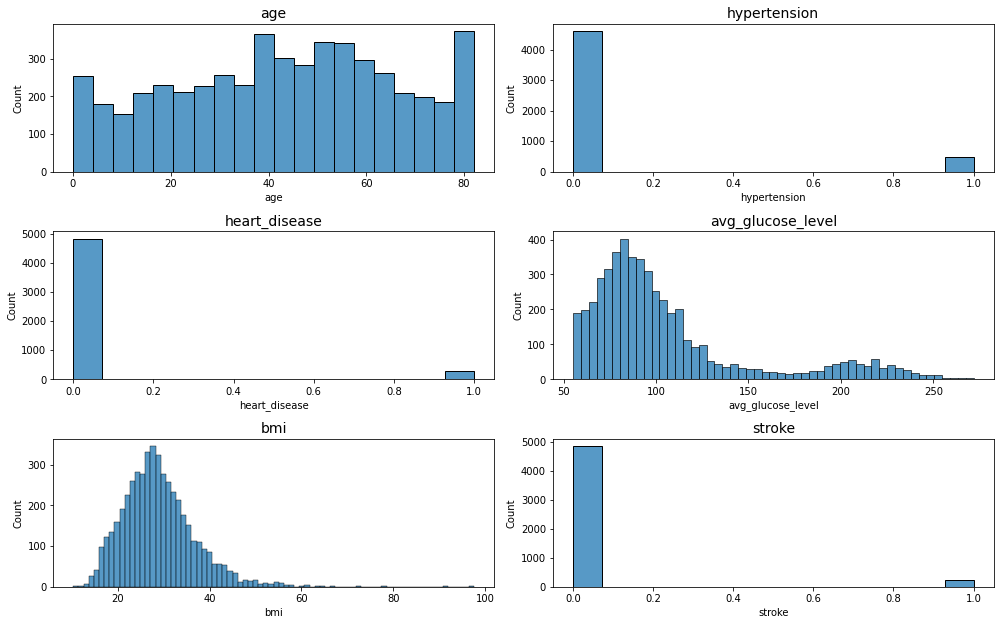

In [11]:
num = df.select_dtypes(exclude='O')

plt.figure(figsize=(14,17))
for i, n in enumerate(num):
  axes = plt.subplot(6,2,i + 1)
  sns.histplot(x=df[n],ax=axes)
  plt.title(n, fontsize=14)
plt.tight_layout()
plt.show()

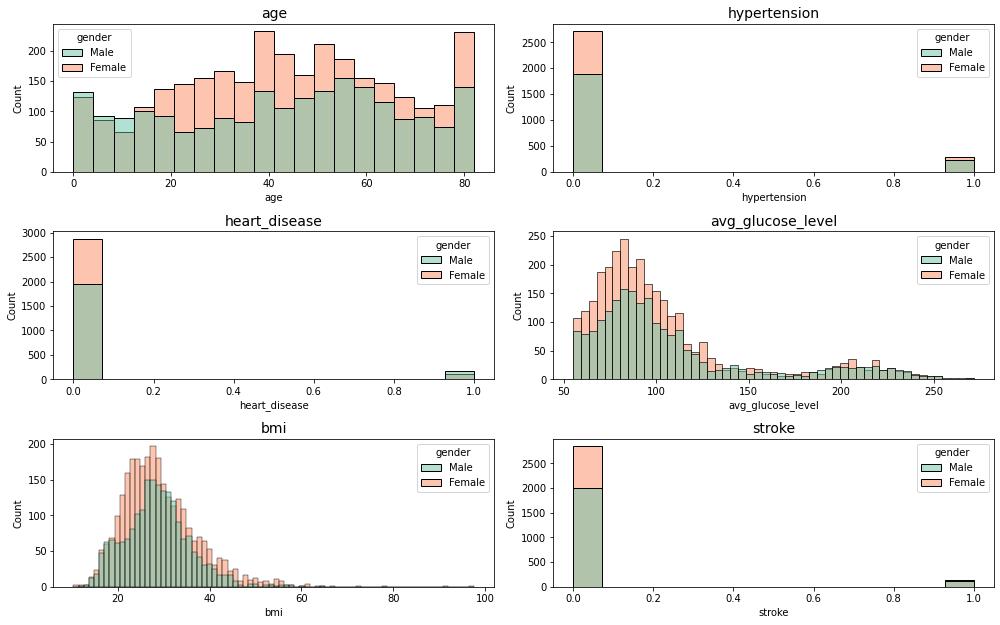

In [12]:
# visualizando qual é o gênero mais frequente com os dados numéricos
plt.figure(figsize=(14,17))
for i, n in enumerate(num):
  axes = plt.subplot(6,2,i + 1)
  sns.histplot(x=df[n], hue=df['gender'],ax=axes, palette='Set2')
  plt.title(n, fontsize=14)
plt.tight_layout()
plt.show()

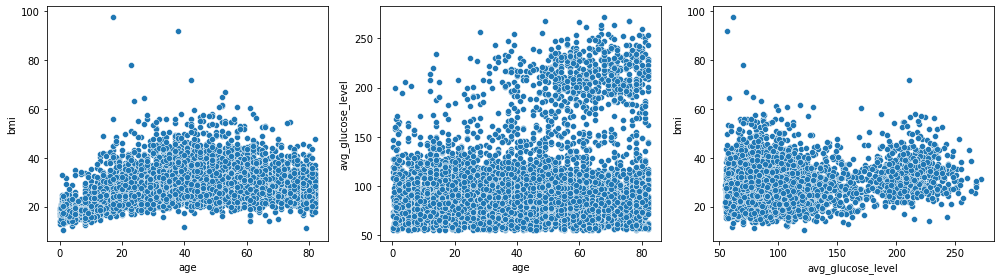

In [13]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
sns.scatterplot(x=df['age'], y=df['bmi'], ax=axes[0])

sns.scatterplot(x=df['age'], y=df['avg_glucose_level'], ax=axes[1])

sns.scatterplot(x=df['avg_glucose_level'], y=df['bmi'], ax=axes[2])

plt.tight_layout()
plt.show()

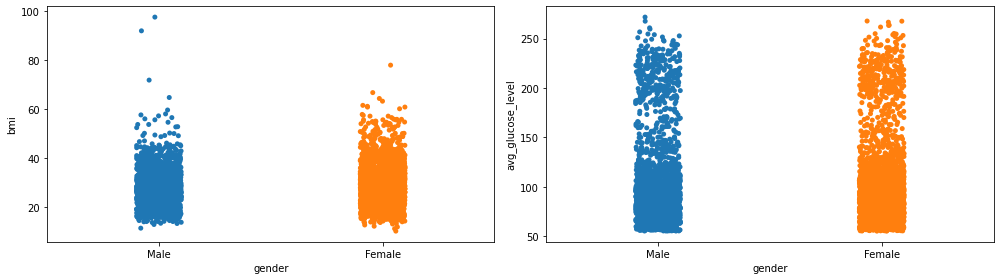

In [14]:
fig,axes = plt.subplots(1,2,figsize=(14,4))
sns.stripplot(x=df['gender'], y=df['bmi'],ax=axes[0])
sns.stripplot(x=df['gender'], y=df['avg_glucose_level'],ax=axes[1])

plt.tight_layout()
plt.show()

In [15]:
df[df['bmi'] > 70]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


# Transformando os Dados
- Antes de jogar os dados nos modelos de classificação, temos que transformar a coluna de BMI, pois ela contém 201 valores ausentes, e para reaproveitar está coluna irei usar o método de imputação que é uma técnica de preencher os dados faltantes com valores plausíveis. Vou utilizar o método SimpleImputer da scikit-learn para isso.

In [16]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(missing_values=np.nan, strategy='mean')
df['bmi'] = impute.fit_transform(df.bmi.values.reshape(-1,1))

cat = df.select_dtypes(include='O')

# One Hot Encoding
df = pd.get_dummies(df, columns = [col for col in df.columns if col in cat])


# Preparação dos Dados

In [17]:
y = df.stroke
x = df.drop('stroke',axis=1)

- Com os dados desequilibrados, usarei o método SMOTE, ele gera novas instâncias de casos minoritários existentes quando fornece como entrada.
??????

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2, random_state=42)

sm = SMOTE(sampling_strategy='auto',random_state=42) 
xtrain, ytrain = sm.fit_resample(xtrain,ytrain)

->->->->-> LOGISTIC <-<-<-<-<-
Train Score: 0.9638461538461538
Test Score: 0.9393346379647749



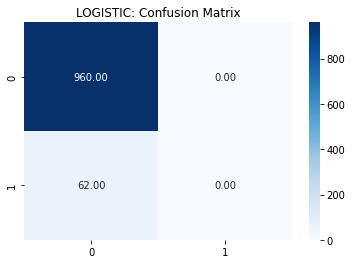


->->->->-> KNN <-<-<-<-<-
Train Score: 0.977948717948718
Test Score: 0.9334637964774951



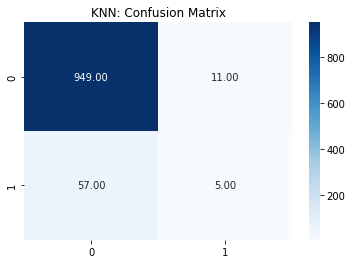


->->->->-> SVC <-<-<-<-<-
Train Score: 0.9673076923076923
Test Score: 0.9354207436399217



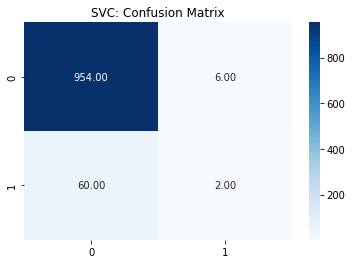


->->->->-> FOREST <-<-<-<-<-
Train Score: 0.8837179487179487
Test Score: 0.7964774951076321



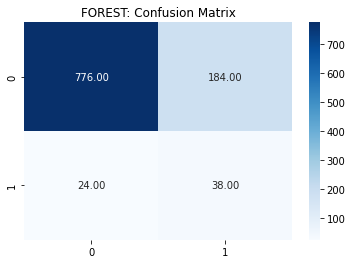


->->->->-> ADA <-<-<-<-<-
Train Score: 0.9591025641025641
Test Score: 0.9383561643835616



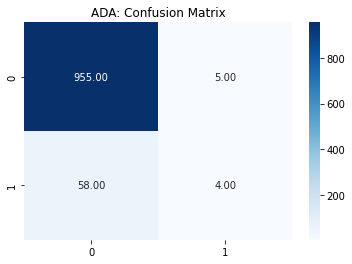


->->->->-> DECISION <-<-<-<-<-
Train Score: 0.8279487179487179
Test Score: 0.7299412915851272



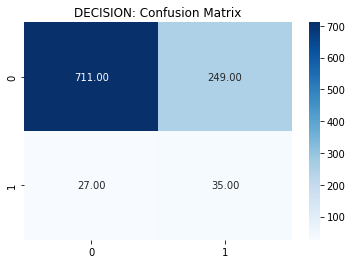


->->->->-> GRADIENT <-<-<-<-<-
Train Score: 0.9771794871794872
Test Score: 0.9383561643835616



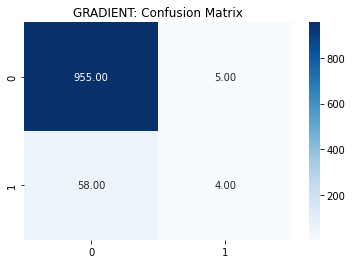


Acúracia dos Modelos


,Models,Score
0,LOGISTIC,0.939335
1,KNN,0.933464
2,SVC,0.935421
3,FOREST,0.796477
4,ADA,0.938356
5,DECISION,0.729941
6,GRADIENT,0.938356


In [19]:
# Escalar os dados
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.fit_transform(xtest)


classifiers = {
      'LOGISTIC':LogisticRegression(),
      'KNN':KNeighborsClassifier(n_neighbors = 5, p = 2),
      'SVC':SVC(kernel = 'poly', degree=4),
      'FOREST': RandomForestClassifier(criterion='entropy',max_depth=4),
      'ADA':AdaBoostClassifier(),
      'DECISION': DecisionTreeClassifier(criterion='entropy', max_depth=4),
      'GRADIENT': GradientBoostingClassifier(max_depth=4)
}

# adicionar todos os modelos dentro de uma lista, para a criação da tabela com a acúracia dos modelos de classificação
modelos = []

for nome, model in classifiers.items():

    model.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)

    # Criando a tabela
    acc = nome, model.score(xtest, ytest)
    modelos.append(acc)
    tabela = pd.DataFrame(modelos, columns=['Models','Score'])

    # imprimindo os modelos
    print('->'*5,nome,'<-'*5)
    print('Train Score:', model.score(xtrain, ytrain))
    print('Test Score:', model.score(xtest, ytest))
    print()

    # matriz de confusão
    cm = confusion_matrix(ytest, y_pred)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(nome + ': Confusion Matrix')
    plt.show()
    print()
print('Acúracia dos Modelos')
display(tabela)
 